# Human Activity Recognition using TSFEL

On this example, we will perform Human Activity Recognition using our library **Time Series Feature Extraction Library**.

To perform this example every cell must be executed. To do so click run ([  ]) in the top left of every cell.

The first step consists of importing the library. To do that press play. 

The import can take a few seconds, but the run button will change so that you know the import has started and ended.

A warning will appear to reset all runtimes before running, click to accept.

In [2]:
import glob
import zipfile

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Import libraries
import tsfel

# Dataset

The dataset we will be using is open-source. It is provided by UCI and it was performed by 30 volunteers using a smartphone on the waist. It contains 6 activities: 

*   Walking
*   Standing
*   Sitting
*   Laying
*   Upstairs
*   Downstairs

The dataset used in this example can be found [here](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones).




In [3]:
# @title Data Preparation

# Load data
x_train_sig = list(np.loadtxt('data/raw/UCI_HAR/train/InertialSignals/total_acc_x_train.txt', dtype='float32'))
x_test_sig = list(np.loadtxt('data/raw/UCI_HAR/test/InertialSignals/total_acc_x_test.txt', dtype='float32'))
y_test = np.loadtxt('data/raw/UCI_HAR/test/y_test.txt')
y_train = np.loadtxt('data/raw/UCI_HAR/train/y_train.txt')
activity_labels = np.array(pd.read_csv('data/raw/UCI_HAR/activity_labels.txt', header=None, delimiter=' '))[:,1]

# dataset sampling frequency
fs = 100

In [4]:
activities_labels = [
    'walking',
    'walking upstairs',
    'walking downstairs',
    'sitting',
    'standing',
    'laying'
]

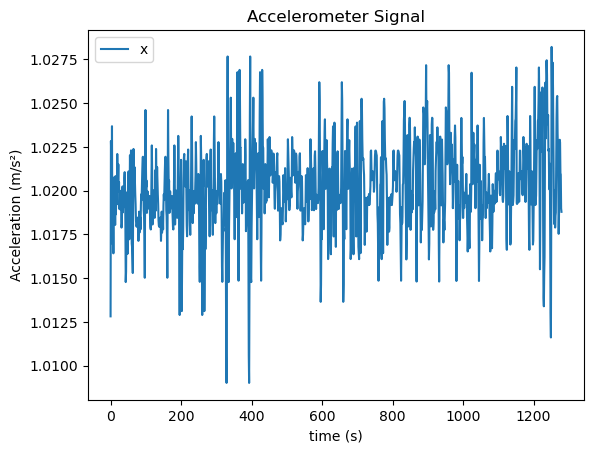

In [5]:
#@title Signal Preview
%matplotlib inline
plt.figure()
plt_size = 10
plt.plot(np.concatenate(x_train_sig[0:plt_size], axis=0))
plt.xlabel("time (s)")
plt.ylabel("Acceleration (m/s²)")
plt.title("Accelerometer Signal")
plt.legend("x axis")
plt.show()

# Feature Extraction

Through **Feature Extraction** methodologies, the data is translated into a feature vector containing information about the signal properties of each window. These properties can be classified according to their domain as Time, Frequency and Statistical features and allow to characterise the signal compactly, enhancing its characteristics. This features will be used as input to the machine learning classifier, thus, the chosen set of features can strongly influence the classification output.

Долго!!!

In [7]:
# @title Feature Extraction
import pandas as pd
cfg_file = tsfel.get_features_by_domain()  # All features
# cfg_file = tsfel.get_features_by_domain('statistical') # Only statistical features
# cfg_file = tsfel.get_features_by_domain('temporal')    # Only temporal features
# cfg_file = tsfel.get_features_by_domain('spectral')    # Only spectral features
EXTRACT = False

if EXTRACT:
    # Get features
    X_train = tsfel.time_series_features_extractor(cfg_file, x_train_sig, fs=fs)
    X_test = tsfel.time_series_features_extractor(cfg_file, x_test_sig, fs=fs)

    X_train.to_csv('data/processed/X_train_tsfel.csv')
    X_test.to_csv('data/processed/X_test_tsfel.csv')
    # y_train.to_csv('data/processed/Y_train_tsfel.csv')
    # y_test.to_csv('data/processed/Y_test_tsfel.csv')
else:
    X_train = pd.read_csv('data/processed/X_train_tsfel.csv', index_col=0)
    X_test = pd.read_csv('data/processed/X_test_tsfel.csv', index_col=0)
    # y_train = pd.read_csv('data/processed/Y_train_tsfel.csv', index_col=0, header=None)
    # y_test = pd.read_csv('data/processed/Y_test_tsfel.csv', index_col=0, header=None)

# Feature Selection

After the sensor data is extracted, redundancies and noise should be removed. Thus, minimising the algorithm's error, time and computational complexity. 

In [8]:
# Highly correlated features are removed
corr_features = tsfel.correlated_features(X_train)
X_train.drop(corr_features, axis=1, inplace=True)
X_test.drop(corr_features, axis=1, inplace=True)

# Remove low variance features
selector = VarianceThreshold()
X_train = selector.fit_transform(X_train)
X_test = selector.transform(X_test)

# Normalising Features
scaler = preprocessing.StandardScaler()
nX_train = scaler.fit_transform(X_train)
nX_test = scaler.transform(X_test)

# Classification

In this example the classification is performed with a [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) classifier.

In [9]:
clf = RandomForestClassifier()
# Train the classifier
clf.fit(nX_train, y_train)

# Predict test data
y_test_predict = clf.predict(nX_test)

# Get the classification report
accuracy = accuracy_score(y_test, y_test_predict) * 100
print("Accuracy on training set is : {}".format(clf.score(nX_train, y_train)))
print("Accuracy on test set is : {}".format(clf.score(nX_test, y_test)))
print(classification_report(y_test, y_test_predict, target_names=activity_labels))
print("Accuracy: " + str(accuracy) + "%")

Accuracy on training set is : 1.0
Accuracy on test set is : 0.8225313878520529
                    precision    recall  f1-score   support

           WALKING       0.85      0.98      0.91       496
  WALKING_UPSTAIRS       0.84      0.85      0.84       471
WALKING_DOWNSTAIRS       0.93      0.76      0.84       420
           SITTING       0.74      0.47      0.58       491
          STANDING       0.64      0.85      0.73       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.82      2947
         macro avg       0.83      0.82      0.82      2947
      weighted avg       0.83      0.82      0.82      2947

Accuracy: 82.2531387852053%


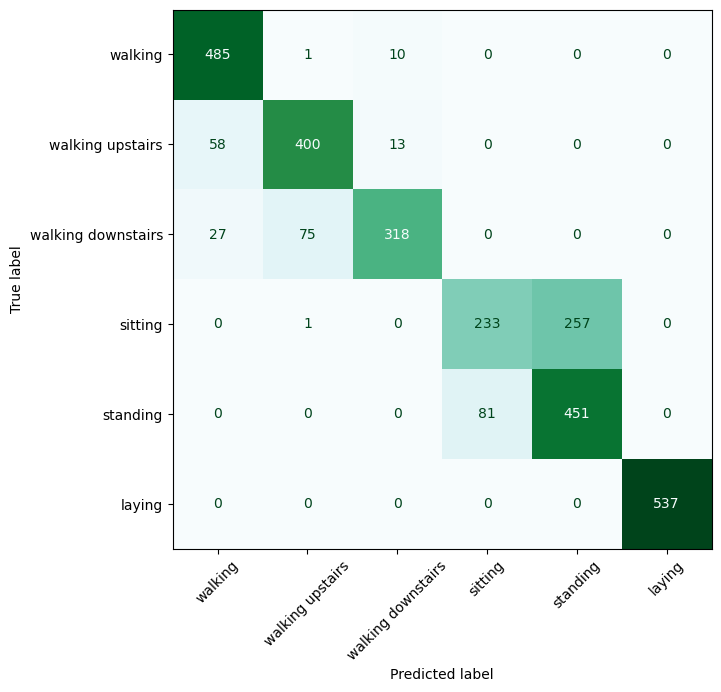

In [10]:
cm = confusion_matrix(y_test, y_test_predict, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=clf.classes_)
fig, ax = plt.subplots(figsize=(7,7))

disp.plot(cmap='BuGn', colorbar=False, ax=ax)
ax.xaxis.set_ticklabels(activities_labels, rotation=45)

ax.yaxis.set_ticklabels(activities_labels)
plt.show()